In [18]:
import torch, torch.nn as nn, torch.utils.data as data, torch.nn.functional as F
from torch.autograd import grad
import lightning as L
import numpy as np
import matplotlib.pyplot as plt

In [107]:
class ODE_Learner(L.LightningModule):
    def __init__(self, init_condition, gamma):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(1, 20),
            nn.Sigmoid(),
            nn.Linear(20, 20),
            nn.Sigmoid(),
            nn.Linear(20, 20),
            nn.Sigmoid(),
            nn.Linear(20, 1)
        )

        self.init_condition = init_condition
        self.gamma = gamma

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def g(self, x, g_t):
        #return self.gamma * g_t
        return 2 * x

    def g_trial(self, x):
        return self.init_condition + self.forward(x)

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x.requires_grad = True
        g_t = self.init_condition + self.forward(x)
        sol = self.gamma * g_t
        dgt_dx = torch.autograd.grad(retain_graph=True, outputs=g_t, 
                                     inputs=x, 
                                     grad_outputs=torch.Tensor([[1] for i in range(len(x))]))[0]

        loss = nn.MSELoss()(dgt_dx, sol)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

In [108]:
class Dataset(data.Dataset):

    def __init__(self, init, end, n):

        self.n = n
        self.x = torch.linspace(init, end, self.n)
        self.y = 10*np.exp(2*self.x)
        #self.y = 10 + self.x**2

    def __len__(self):

        return self.n

    def __getitem__(self, idx):

        x = self.x[idx, np.newaxis]
        y = self.y[idx, np.newaxis]

        return torch.Tensor(x), torch.Tensor(y)

In [109]:
train = Dataset(0, 2, 100)

trainer = L.Trainer(logger=False, max_epochs=10000)
learner = ODE_Learner(10, 2)
trainer.fit(learner, data.DataLoader(train, batch_size=10))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | Sequential | 901   
-------------------------------------
901       Trainable params
0         Non-trainable params
901       Total params
0.004     Total estimated model params size (MB)


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=10000` reached.


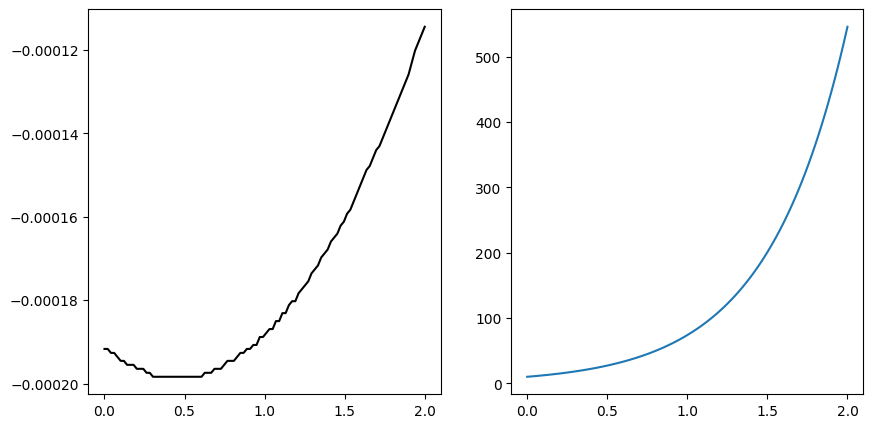

In [110]:
y = learner.model.forward(train.x.view(100, 1))
y = y.detach().cpu()
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)

ax.plot(train.x, 10 + y.flatten(), color='black')

ax1 = fig.add_subplot(122)
ax1.plot(train.x, train.y)